# Emargo Simulation

## Imports

In [1]:
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from network_regression_model import NetworkRegressionModel
from utils import *


In [2]:
results_dict = {} 

## 1. Load the data

In [3]:
# Consider only G20 countries
G20 = [
    "Argentina",
    "Australia",
    "Brazil",
    "Canada",
    "China (mainland)",
    "France",
    "Germany",
    "India",
    "Indonesia",
    "Italy",
    "Japan",
    "South Korea",
    "Mexico",
    "Russia",
    "Saudi Arabia",
    "South Africa",
    "Turkey",
    "United Kingdom",
    "United States",
]

# Load and process metals data
metals = read_clean_data("metals", resolution="annual")
metals = (
    metals.groupby(["ImporterCountry", "ExporterCountry"])
    .sum(numeric_only=True)
    .reset_index(drop=False)
)
metals_g20 = metals[
    metals["ImporterCountry"].isin(G20) & metals["ExporterCountry"].isin(G20)
    ]
metals_g20 = metals_g20.iloc[:, :-12]
metals_g20.head(20)

,ImporterCountry,ExporterCountry,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,2022-01-01
269,Argentina,Australia,4.053141e+05,3.479694e+05,9.620133e+05,6.227539e+05,3.573832e+05,1.755241e+05,1.266805e+05,1.544350e+05,3.036021e+04,4.082109e+05,2.933476e+05,1.694225e+05,1.312200e+05,7.142021e+04,5.062388e+04,3.832025e+04,1.882934e+05,2.119349e+05
275,Argentina,Brazil,8.158161e+08,8.366489e+08,1.006904e+09,1.167478e+09,7.616588e+08,9.850422e+08,1.067263e+09,1.042977e+09,9.490566e+08,7.888791e+08,9.759517e+08,8.612868e+08,1.336298e+09,8.826677e+08,6.455113e+08,7.021814e+08,1.370078e+09,1.148135e+09
276,Argentina,Canada,4.096314e+06,6.144215e+06,5.656792e+06,6.403578e+06,3.350211e+06,5.811609e+06,5.131252e+06,6.873163e+06,1.364855e+07,1.903818e+07,8.914779e+06,6.155323e+06,7.490684e+06,7.668153e+06,9.888260e+06,4.500754e+06,7.497772e+06,9.434400e+06
278,Argentina,China (mainland),9.642646e+07,1.310470e+08,2.021905e+08,2.340041e+08,1.359452e+08,1.780829e+08,2.487538e+08,2.091762e+08,1.951969e+08,2.575594e+08,3.622161e+08,2.876946e+08,3.105927e+08,3.314886e+08,3.017295e+08,2.484670e+08,3.626035e+08,4.316853e+08
288,Argentina,France,2.980556e+07,3.239960e+07,3.087750e+07,3.257935e+07,2.618979e+07,5.149253e+07,5.746171e+07,4.669864e+07,4.418438e+07,4.827823e+07,5.376215e+07,1.996562e+07,2.066887e+07,1.750688e+07,9.789361e+06,7.395827e+06,1.251013e+07,8.878332e+06
289,Argentina,Germany,5.465201e+07,5.551508e+07,8.188657e+07,1.016084e+08,7.360471e+07,1.383862e+08,1.225640e+08,1.205737e+08,1.176406e+08,1.130362e+08,1.811258e+08,9.091859e+07,9.205183e+07,9.580167e+07,8.186950e+07,7.271620e+07,8.324589e+07,1.095740e+08
295,Argentina,India,6.799496e+06,1.348476e+07,1.406558e+07,1.785424e+07,1.085749e+07,1.364855e+07,1.232032e+07,1.251959e+07,2.119319e+07,6.005304e+07,3.558854e+07,2.086702e+07,3.456871e+07,6.550840e+07,3.093200e+07,1.652164e+07,8.904703e+07,5.210964e+07
296,Argentina,Indonesia,2.144305e+05,3.465411e+05,6.741255e+05,4.562290e+05,3.487272e+05,5.825754e+05,5.659028e+05,4.414627e+05,5.190200e+05,5.981206e+05,1.009522e+06,2.584541e+06,3.715233e+06,3.274719e+06,3.123854e+06,2.578886e+06,3.590002e+06,3.535363e+06
299,Argentina,Italy,5.130775e+07,7.420081e+07,6.348372e+07,5.764067e+07,4.732809e+07,5.228922e+07,6.654771e+07,7.932854e+07,6.650959e+07,9.438073e+07,5.586580e+07,4.115653e+07,5.104510e+07,5.252839e+07,3.940332e+07,3.335046e+07,4.448030e+07,5.104716e+07
300,Argentina,Japan,2.798978e+07,2.318155e+07,4.977515e+07,4.161726e+07,1.810174e+07,2.143632e+07,2.620781e+07,2.976693e+07,2.247301e+07,2.436148e+07,2.358795e+07,1.684619e+07,1.829526e+07,2.033752e+07,1.728066e+07,1.872411e+07,2.530581e+07,2.483375e+07


## 2. Train a model to predict trade volumes

In [4]:
# Make a new version of the network
metals = metals_g20.copy()
original_G = build_network(metals)

# Initialise custom model
model = NetworkRegressionModel()

# Extract features and target
X, y = model.extract_features_and_target(original_G, 2021)  # Setup to use 2005-2020 data to predict 2021
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data into training and test sets of country pairs

# Train the model (untuned)
model.fit(X_train, y_train)
print("Untuned RRMSE", model.score(X_test, y_test))

Untuned RRMSE 0.05504974389879761


In [5]:
# Hyperparameter tuning
param_grid = {
    "model__max_depth": [None, 10, 20, 30, 40, 50],
    "model__min_samples_split": [2, 5, 10, 15, 20],
    "model__min_samples_leaf": [1, 2, 3, 4, 5],
}
grid_search = GridSearchCV(
    model, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2
)  # Use negative MSE as scoring metric
grid_search.fit(X, y)

# Determine the best model
print("Best parameters:", grid_search.best_params_)
model = grid_search.best_estimator_

# Evaluate the tuned model
print("Tuned RRMSE", model.score(X_test, y_test))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5; total time=   0.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5; total time=   0.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=10; total time=   0.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=10; 

In [6]:
# Try to predict the trade volumes for year not in the training data and that was not original target
X, y = model.extract_features_and_target(original_G, 2022)
y_pred = model.predict(X)

comparison_df = pd.concat(
    [metals_g20["2022-01-01"].reset_index(drop=True), pd.DataFrame(y_pred)], axis=1
)
comparison_df.columns = ["Actual", "Predicted"]
comparison_df["Difference"] = comparison_df["Actual"] - comparison_df["Predicted"]
print("RRMSE for 2022:", model.score(X, y))
comparison_df.head(10)

RRMSE for 2022: 0.026269907452932614


,Actual,Predicted,Difference
0,2.119349e+05,2.243271e+05,-1.239227e+04
1,1.148135e+09,1.213360e+09,-6.522483e+07
2,9.434400e+06,1.226650e+07,-2.832099e+06
3,4.316853e+08,2.711858e+08,1.604995e+08
4,8.878332e+06,1.297724e+07,-4.098906e+06
5,1.095740e+08,9.178783e+07,1.778613e+07
6,5.210964e+07,5.253375e+07,-4.241158e+05
7,3.535363e+06,1.330962e+06,2.204400e+06
8,5.104716e+07,2.909612e+07,2.195104e+07
9,2.483375e+07,1.297724e+07,1.185651e+07


## 3. Simulate an embargo

In [7]:
def simulate_embargo(G, embargoed_country, embargo_date_str, cap):
    """
    Apply the embargo cap to the exports from the embargoed country and redistribute trade volumes.
    """
    G_cpy = G.copy()
    # Apply embargo
    embargo_date = datetime.strptime(embargo_date_str, "%Y-%m-%d").date()
    for u, v, key, data in G.edges(data=True, keys=True):
        if "original_weight" not in data:
            G_cpy[u][v][key]["original_weight"] = G[u][v][key]["weight"]
        if u == embargoed_country and data["date"].date() == embargo_date:
            G_cpy[u][v][key]["weight"] = min(data.get("weight", 0), cap)

    # Calculate import deficits for countries effected by the embargo
    import_deficits = {country: 0 for country in G.nodes()}
    for u, v, data in G_cpy.edges(data=True):
        if data["date"].date() == embargo_date:
            deficit_increase = (
                    data.get("original_weight", data["weight"]) - data["weight"]
            )
            import_deficits[v] += deficit_increase

    # Redistribute trade volumes to reduce import deficits
    edges = [
        (u, v, key, data)
        for u, v, key, data in G_cpy.edges(data=True, keys=True)
        if data.get("date").date() == embargo_date and u != embargoed_country
    ]
    random.Random(x=42).shuffle(
        edges
    )  # Randomise edges to distribute increases more evenly, seed = 42
    for country, original_deficit in import_deficits.items():
        if original_deficit > 0:
            for u, v, key, data in edges:
                if v == country:
                    original_weight = data.get("original_weight", data["weight"])
                    max_allowed_increase = (
                            original_weight * 0.05
                    )  # 5% of original weight of original edge weight
                    potential_increase = min(max_allowed_increase, original_deficit)
                    increase = min(
                        potential_increase,
                        original_weight + max_allowed_increase - data["weight"],
                    )
                    G_cpy[u][v][key]["weight"] += increase
                    original_deficit -= increase
                    if original_deficit <= 0:
                        break
            import_deficits[country] = max(original_deficit, 0)
    return G_cpy

In [8]:
# Build the network
G = build_network(metals_g20)

# Decide embargo parameters
embargoed_country = "Japan"
embargo_date = "2014-01-01"
year_before = str(int(embargo_date.split("-")[0]) - 1) + "-01-01"
# avg_exports = metals_g20[metals_g20["ExporterCountry"] == embargoed_country][year_before].mean()
std_exports = metals_g20[metals_g20["ExporterCountry"] == embargoed_country][
    year_before
].std()
cap = (
    std_exports * 0.1 # Cap trade at 0.1 standard deviations below the mean of previous year
)

# Simulate the embargo
embargoed_G = simulate_embargo(
    G=G, embargoed_country=embargoed_country, embargo_date_str=embargo_date, cap=cap
)

# Get the snapshots of the embargoed network and the original network at the embargo date
original_snapshot = model.create_static_snapshot(original_G, year=int(embargo_date.split("-")[0]))
embargo_snapshot = model.create_static_snapshot(embargoed_G, year=int(embargo_date.split("-")[0]))

In [9]:
embargo_snapshot.edges(data=True)

OutEdgeDataView([('Argentina', 'Australia', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'weight': 2036426.28, 'original_weight': 1939453.6}), ('Argentina', 'Brazil', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'weight': 355501914.96, 'original_weight': 355501914.96}), ('Argentina', 'Canada', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'weight': 11192647.19, 'original_weight': 11192647.19}), ('Argentina', 'China (mainland)', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'weight': 3519673.353, 'original_weight': 3352069.86}), ('Argentina', 'France', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'weight': 13562782.49, 'original_weight': 13562782.49}), ('Argentina', 'Germany', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'weight': 3268106.0, 'original_weight': 3268106.0}), ('Argentina', 'India', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'weight': 484883.6265, 'original_weight': 461793.93}), ('Argentina', 'Indonesia', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'weight': 134534

In [10]:
def compare_network_metrics(original_G, embargoed_G):
    degree_centrality_changes = compare_degree_centrality(original_G, embargoed_G)
    betweeness_centrality_changes = compare_weighted_betweenness_centrality(original_G, embargoed_G)
    node_strength_changes = compare_strength_distribution(original_G, embargoed_G)
    clustering_changes = compare_weighted_clustering_coefficient(original_G, embargoed_G)
    hierarchy_change = compare_flow_hierarchy(original_G, embargoed_G)
    import_export_ratio_changes = compare_import_export_ratios(original_G, embargoed_G)
    lev_centrality_changes = compare_leverage_centrality(original_G, embargoed_G)
    pagerank_changes = compare_pagerank(original_G, embargoed_G)
    entropy_change = compare_edge_weight_entropy(original_G, embargoed_G)
    orig_weights, embargoed_weights = compare_weight_changes(original_G, embargoed_G)

    return {
        'degree_centrality_changes': degree_centrality_changes, # Doesn't change, not informative
        'betweenesss_centrality_changes': betweeness_centrality_changes, # Some changed
        'node_strength_changes': node_strength_changes,
        'clustering_changes': clustering_changes,
        'hierarchy_change': hierarchy_change,
        'import_export_ratio_changes': import_export_ratio_changes,
        'entropy_change': entropy_change,
        'lev_centrality_changes': lev_centrality_changes,
        'pagerank_changes': pagerank_changes,
        'orig_weights': orig_weights,
        'embargoed_weights': embargoed_weights
    }

In [11]:
results = compare_network_metrics(original_snapshot, embargo_snapshot)
results_dict[2014] = results # By Jason to collect
results

{'degree_centrality_changes': {'Argentina': 0.0,
  'South Korea': 0.0,
  'Brazil': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'Indonesia': 0.0,
  'South Africa': 0.0,
  'Saudi Arabia': 0.0,
  'United Kingdom': 0.0,
  'France': 0.0,
  'Mexico': 0.0,
  'Australia': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'Russia': 0.0,
  'China (mainland)': 0.0,
  'Turkey': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'betweenesss_centrality_changes': {'Argentina': 0.0,
  'South Korea': 0.0,
  'Brazil': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'Indonesia': 0.0,
  'South Africa': 0.0,
  'Saudi Arabia': 0.0,
  'United Kingdom': 0.0,
  'France': 0.0,
  'Mexico': 0.0,
  'Australia': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'Russia': 0.0,
  'China (mainland)': 0.0,
  'Turkey': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'node_strength_changes': {'Japan': -25015621437.80859,
  'China (mainland)': -5983147867.317627,
  'South Korea': -4420320160.93605,
  'Indonesia': -1647122905.0488815,
  'Canada': 815702993

## 4. Predict the next year (2015)

In [12]:
# Use the model to predict the trade volumes for the next year
X, y = model.extract_features_and_target(embargoed_G, int(embargo_date.split("-")[0]) + 1)
y_pred = model.predict(X)
embargoed_G = model.append_prediction_to_network(G=embargoed_G, year=int(embargo_date.split("-")[0]) + 1, prediction=y_pred)

# Enforce the embargo cap on the predicted trade volumes
embargoed_G = simulate_embargo(G=embargoed_G, embargoed_country=embargoed_country, embargo_date_str=str(int(embargo_date.split("-")[0]) + 1) + "-01-01", cap=cap)

# Get the snapshots of the embargoed network and the original network at the embargo date
original_snapshot = model.create_static_snapshot(original_G, year=int(embargo_date.split("-")[0]) + 1)
embargo_snapshot = model.create_static_snapshot(embargoed_G, year=int(embargo_date.split("-")[0]) + 1)

In [13]:
results = compare_network_metrics(original_snapshot, embargo_snapshot)
results_dict[2015] = results # By Jason to collect
results

{'degree_centrality_changes': {'Argentina': 0.0,
  'South Korea': 0.0,
  'Brazil': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'Indonesia': 0.0,
  'South Africa': 0.0,
  'Saudi Arabia': 0.0,
  'United Kingdom': 0.0,
  'France': 0.0,
  'Mexico': 0.0,
  'Australia': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'Russia': 0.0,
  'China (mainland)': 0.0,
  'Turkey': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'betweenesss_centrality_changes': {'Australia': 0.1928104575163399,
  'Indonesia': -0.13071895424836602,
  'Turkey': 0.11764705882352941,
  'Saudi Arabia': 0.09150326797385622,
  'Russia': 0.0392156862745098,
  'Mexico': -0.03594771241830066,
  'Argentina': 0.02941176470588236,
  'South Africa': 0.013071895424836596,
  'United Kingdom': 0.0032679738562091504,
  'South Korea': 0.0,
  'Brazil': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'France': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'China (mainland)': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'node_strength_changes': {'United States': 

## 5. Predict the next year (2016)

In [14]:
# Use the model to predict the trade volumes for the next year
X, y = model.extract_features_and_target(embargoed_G, int(embargo_date.split("-")[0]) + 2)
y_pred = model.predict(X)
embargoed_G = model.append_prediction_to_network(G=embargoed_G, year=int(embargo_date.split("-")[0]) + 2, prediction=y_pred)

# Enforce the embargo cap on the predicted trade volumes
embargoed_G = simulate_embargo(G=embargoed_G, embargoed_country=embargoed_country, embargo_date_str=str(int(embargo_date.split("-")[0]) + 2) + "-01-01", cap=cap)

# Get the snapshots of the embargoed network and the original network at the embargo date
original_snapshot = model.create_static_snapshot(original_G, year=int(embargo_date.split("-")[0]) + 2)
embargo_snapshot = model.create_static_snapshot(embargoed_G, year=int(embargo_date.split("-")[0]) + 2)

In [15]:
results = compare_network_metrics(original_snapshot, embargo_snapshot)
results_dict[2016] = results # By Jason to collect
results

{'degree_centrality_changes': {'Argentina': 0.0,
  'South Korea': 0.0,
  'Brazil': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'Indonesia': 0.0,
  'South Africa': 0.0,
  'Saudi Arabia': 0.0,
  'United Kingdom': 0.0,
  'France': 0.0,
  'Mexico': 0.0,
  'Australia': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'Russia': 0.0,
  'China (mainland)': 0.0,
  'Turkey': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'betweenesss_centrality_changes': {'Australia': 0.14705882352941177,
  'Argentina': -0.1307189542483661,
  'Turkey': 0.10784313725490197,
  'Saudi Arabia': 0.1045751633986928,
  'Indonesia': 0.06535947712418302,
  'United Kingdom': 0.05555555555555556,
  'Russia': 0.0196078431372549,
  'South Korea': 0.0,
  'Brazil': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'South Africa': 0.0,
  'France': 0.0,
  'Mexico': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'China (mainland)': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'node_strength_changes': {'United States': 34448169772.142914,
  'Japan': -19862

## 6. Predict the next year (2017)

In [16]:
X, y = model.extract_features_and_target(embargoed_G, int(embargo_date.split("-")[0]) + 3)
y_pred = model.predict(X)
embargoed_G = model.append_prediction_to_network(G=embargoed_G, year=int(embargo_date.split("-")[0]) + 3, prediction=y_pred)

# Enforce the embargo cap on the predicted trade volumes
embargoed_G = simulate_embargo(G=embargoed_G, embargoed_country=embargoed_country, embargo_date_str=str(int(embargo_date.split("-")[0]) + 3) + "-01-01", cap=cap)

# Get the snapshots of the embargoed network and the original network at the embargo date
original_snapshot = model.create_static_snapshot(original_G, year=int(embargo_date.split("-")[0]) + 3)
embargo_snapshot = model.create_static_snapshot(embargoed_G, year=int(embargo_date.split("-")[0]) + 3)

In [17]:
results = compare_network_metrics(original_snapshot, embargo_snapshot)
results_dict[2017] = results # By Jason to collect
results

{'degree_centrality_changes': {'Argentina': 0.0,
  'South Korea': 0.0,
  'Brazil': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'Indonesia': 0.0,
  'South Africa': 0.0,
  'Saudi Arabia': 0.0,
  'United Kingdom': 0.0,
  'France': 0.0,
  'Mexico': 0.0,
  'Australia': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'Russia': 0.0,
  'China (mainland)': 0.0,
  'Turkey': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'betweenesss_centrality_changes': {'Saudi Arabia': 0.20588235294117646,
  'Argentina': -0.13725490196078438,
  'Australia': 0.08169934640522875,
  'Brazil': 0.06209150326797386,
  'Canada': -0.05555555555555556,
  'Russia': -0.05555555555555556,
  'Indonesia': -0.049019607843137275,
  'Turkey': 0.022875816993464054,
  'South Africa': -0.0032679738562091504,
  'South Korea': 0.0,
  'India': 0.0,
  'United Kingdom': 0.0,
  'France': 0.0,
  'Mexico': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'China (mainland)': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'node_strength_changes': {'United Sta

##  7. Predict the next year (2018)

In [18]:
X, y = model.extract_features_and_target(embargoed_G, int(embargo_date.split("-")[0]) + 4)
y_pred = model.predict(X)
embargoed_G = model.append_prediction_to_network(G=embargoed_G, year=int(embargo_date.split("-")[0]) + 4, prediction=y_pred)

# Enforce the embargo cap on the predicted trade volumes
embargoed_G = simulate_embargo(G=embargoed_G, embargoed_country=embargoed_country, embargo_date_str=str(int(embargo_date.split("-")[0]) + 4) + "-01-01", cap=cap)

# Get the snapshots of the embargoed network and the original network at the embargo date
original_snapshot = model.create_static_snapshot(original_G, year=int(embargo_date.split("-")[0]) + 4)
embargo_snapshot = model.create_static_snapshot(embargoed_G, year=int(embargo_date.split("-")[0]) + 4)

In [19]:
results = compare_network_metrics(original_snapshot, embargo_snapshot)
results_dict[2018] = results # By Jason to collect
results

{'degree_centrality_changes': {'Argentina': 0.0,
  'South Korea': 0.0,
  'Brazil': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'Indonesia': 0.0,
  'South Africa': 0.0,
  'Saudi Arabia': 0.0,
  'United Kingdom': 0.0,
  'France': 0.0,
  'Mexico': 0.0,
  'Australia': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'Russia': 0.0,
  'China (mainland)': 0.0,
  'Turkey': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'betweenesss_centrality_changes': {'Saudi Arabia': 0.23202614379084968,
  'Indonesia': 0.16013071895424835,
  'Australia': 0.12418300653594772,
  'South Africa': 0.058823529411764705,
  'Turkey': 0.0588235294117647,
  'Argentina': -0.04575163398692805,
  'Brazil': 0.032679738562091505,
  'Russia': -0.016339869281045756,
  'Mexico': -0.013071895424836596,
  'South Korea': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'United Kingdom': 0.0,
  'France': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'China (mainland)': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'node_strength_changes': {'United States

## 8. Predict the next year (2019) - End of embargo

In [20]:
X, y = model.extract_features_and_target(embargoed_G, int(embargo_date.split("-")[0]) + 5)
y_pred = model.predict(X)
embargoed_G = model.append_prediction_to_network(G=embargoed_G, year=int(embargo_date.split("-")[0]) + 5, prediction=y_pred)

# Get the snapshots of the embargoed network and the original network at the embargo date
original_snapshot = model.create_static_snapshot(original_G, year=int(embargo_date.split("-")[0]) + 5)
embargo_snapshot = model.create_static_snapshot(embargoed_G, year=int(embargo_date.split("-")[0]) + 5)

In [21]:
results = compare_network_metrics(original_snapshot, embargo_snapshot)
results_dict[2019] = results # By Jason to collect
results

{'degree_centrality_changes': {'Argentina': 0.0,
  'South Korea': 0.0,
  'Brazil': 0.0,
  'India': 0.0,
  'Canada': 0.0,
  'Indonesia': 0.0,
  'South Africa': 0.0,
  'Saudi Arabia': 0.0,
  'United Kingdom': 0.0,
  'France': 0.0,
  'Mexico': 0.0,
  'Australia': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'Russia': 0.0,
  'China (mainland)': 0.0,
  'Turkey': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'betweenesss_centrality_changes': {'Saudi Arabia': 0.3888888888888889,
  'Turkey': 0.22222222222222224,
  'Indonesia': -0.20915032679738563,
  'Argentina': -0.16993464052287588,
  'United Kingdom': 0.09477124183006536,
  'Brazil': 0.05228758169934641,
  'Mexico': -0.05228758169934641,
  'Canada': 0.0392156862745098,
  'Australia': 0.0326797385620915,
  'South Africa': 0.00980392156862745,
  'South Korea': 0.0,
  'India': 0.0,
  'France': 0.0,
  'Japan': 0.0,
  'Germany': 0.0,
  'Russia': 0.0,
  'China (mainland)': 0.0,
  'United States': 0.0,
  'Italy': 0.0},
 'node_strength_changes': {'Uni

In [22]:
model.score(X, pd.Series(results['orig_weights']))  # Should be relatively high to show that the embargoed network has evolved differently to the original

0.16875125538484437

## Show final network

In [23]:
embargoed_G = model.cut_network_by_year(embargoed_G, int(embargo_date.split("-")[0]) + 5)
embargoed_G.edges(data=True)

OutMultiEdgeDataView([('Argentina', 'Australia', {'date': datetime.datetime(2005, 1, 1, 0, 0), 'weight': 1378994.39}), ('Argentina', 'Australia', {'date': datetime.datetime(2006, 1, 1, 0, 0), 'weight': 2971819.37}), ('Argentina', 'Australia', {'date': datetime.datetime(2007, 1, 1, 0, 0), 'weight': 1332274.56}), ('Argentina', 'Australia', {'date': datetime.datetime(2008, 1, 1, 0, 0), 'weight': 8655240.67}), ('Argentina', 'Australia', {'date': datetime.datetime(2009, 1, 1, 0, 0), 'weight': 3232754.18}), ('Argentina', 'Australia', {'date': datetime.datetime(2010, 1, 1, 0, 0), 'weight': 1829921.1}), ('Argentina', 'Australia', {'date': datetime.datetime(2011, 1, 1, 0, 0), 'weight': 11698124.76}), ('Argentina', 'Australia', {'date': datetime.datetime(2012, 1, 1, 0, 0), 'weight': 913862.0499999999}), ('Argentina', 'Australia', {'date': datetime.datetime(2013, 1, 1, 0, 0), 'weight': 1186808.5999999999}), ('Argentina', 'Australia', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'weight': 2036426

In [24]:
from network_utils import *
import networkx as nx

In [25]:
list(results_dict[2014].keys())

['degree_centrality_changes',
 'betweenesss_centrality_changes',
 'node_strength_changes',
 'clustering_changes',
 'hierarchy_change',
 'import_export_ratio_changes',
 'entropy_change',
 'lev_centrality_changes',
 'pagerank_changes',
 'orig_weights',
 'embargoed_weights']

---

#### Visualisation 2014-2019

random seed: 42


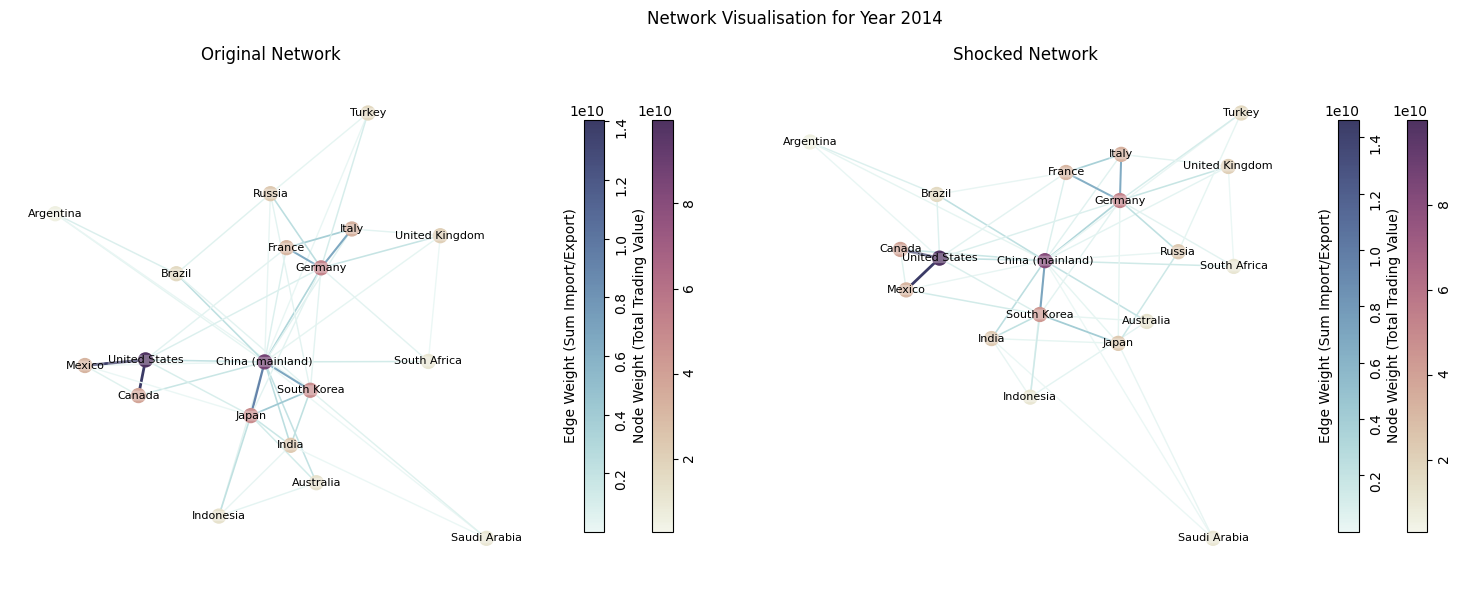

louvain_communities found 3 communities
louvain_communities found 3 communities


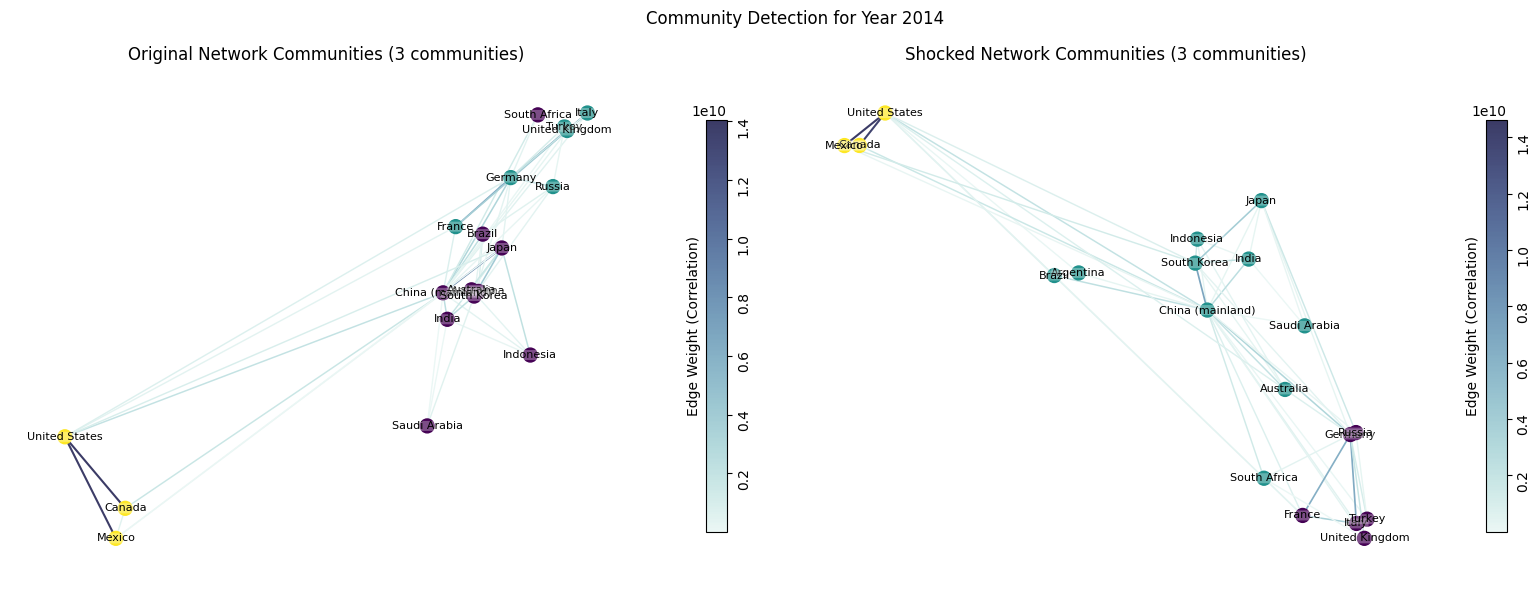

random seed: 42


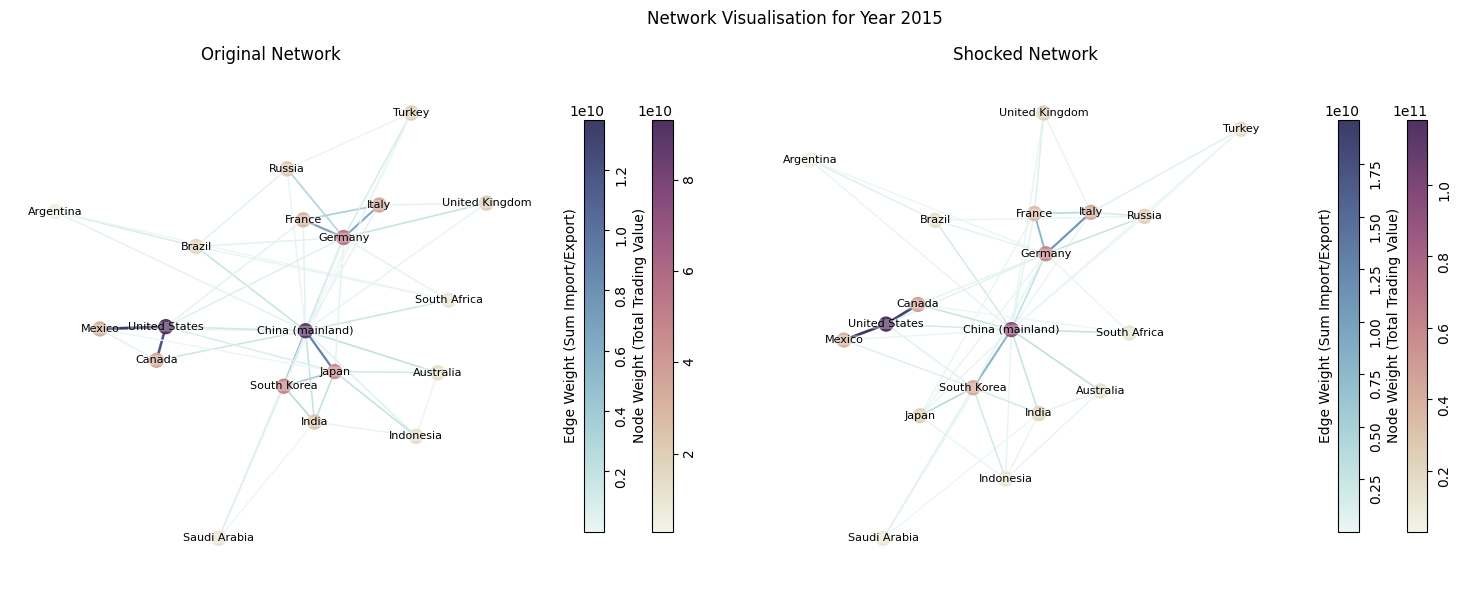

louvain_communities found 3 communities
louvain_communities found 3 communities


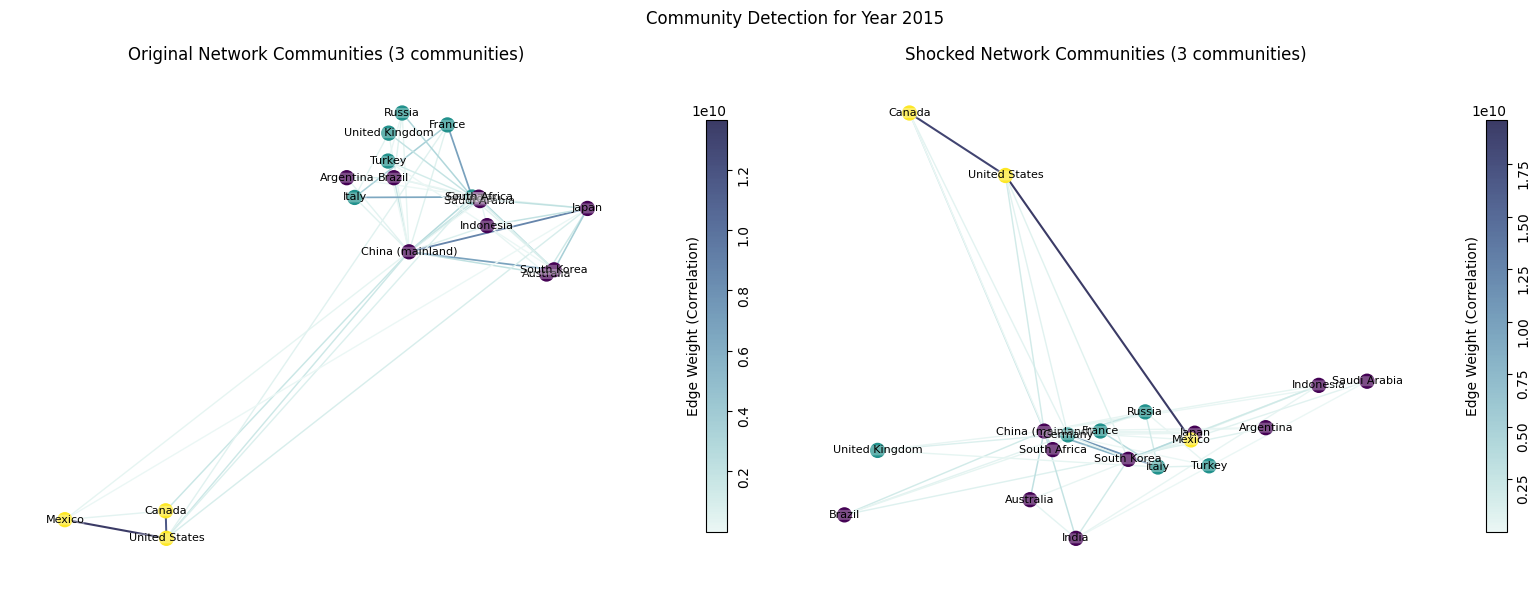

random seed: 42


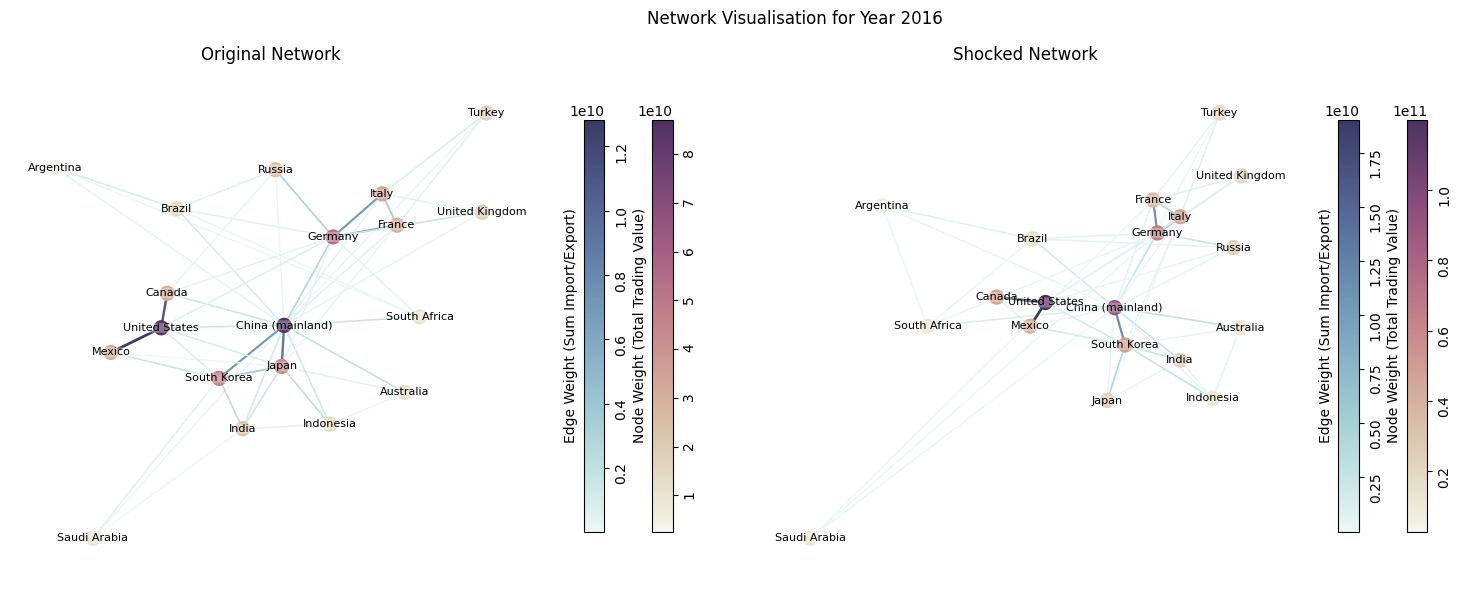

louvain_communities found 4 communities
louvain_communities found 3 communities


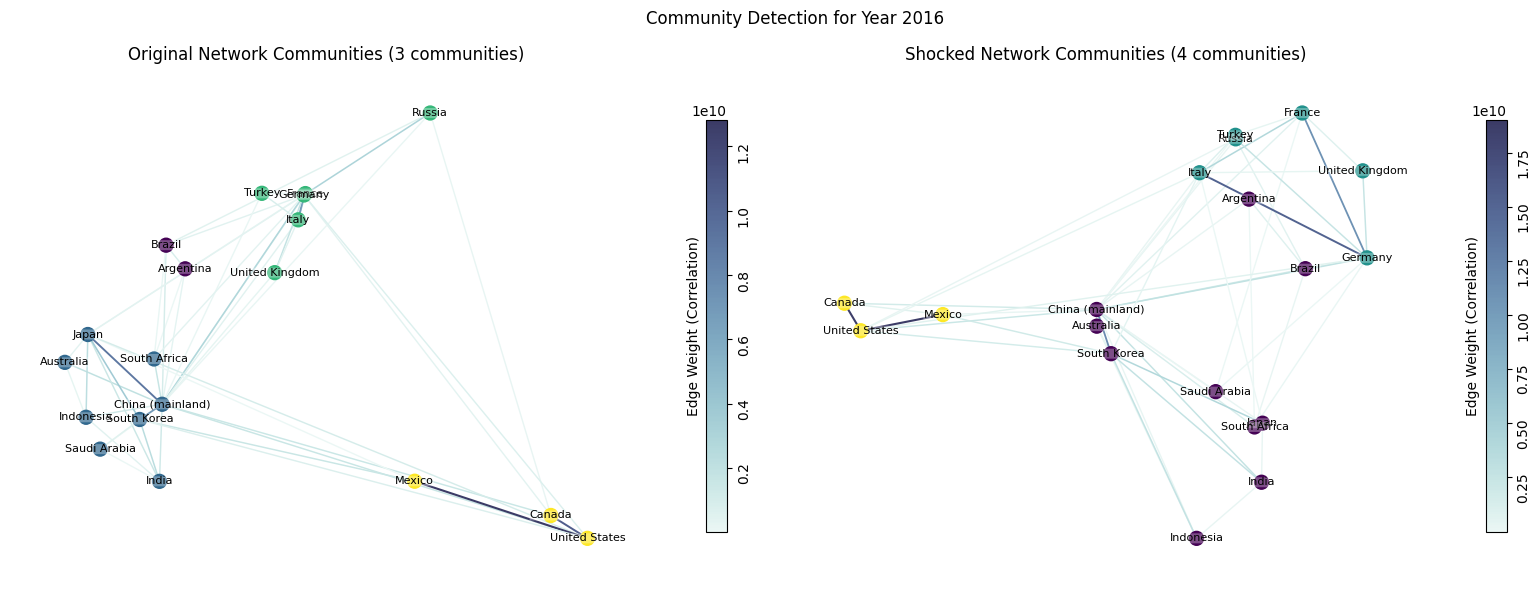

random seed: 42


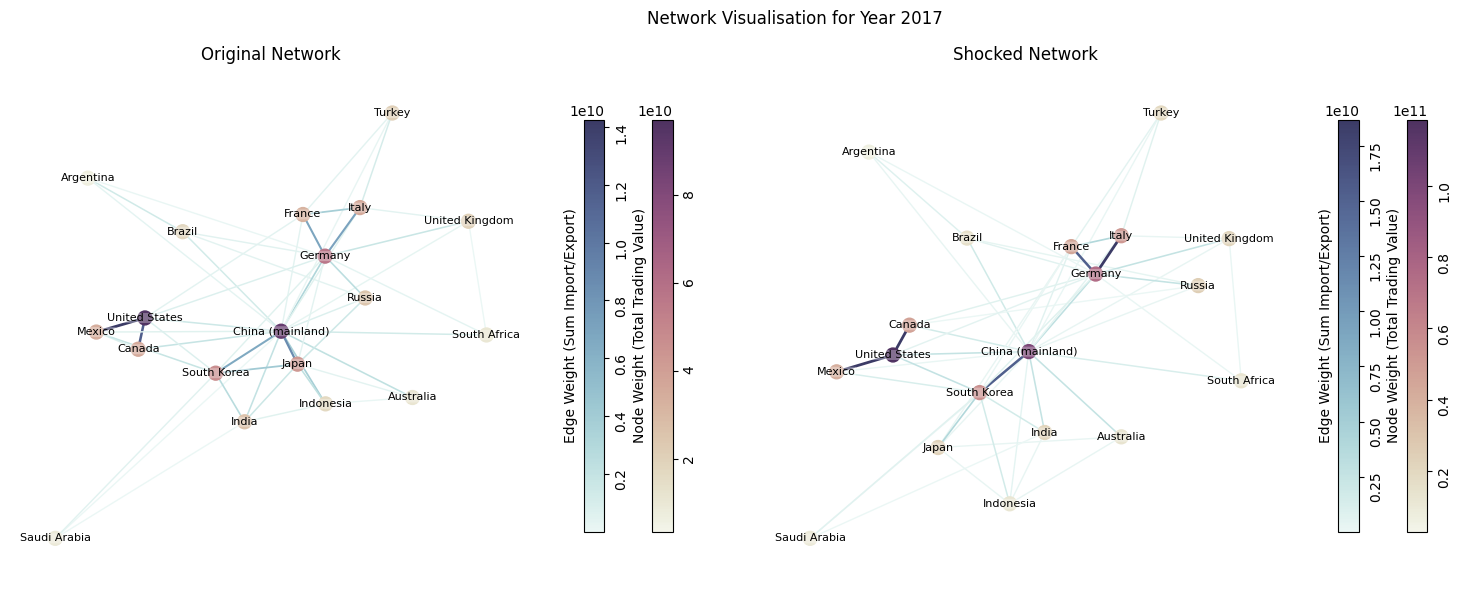

louvain_communities found 4 communities
louvain_communities found 3 communities


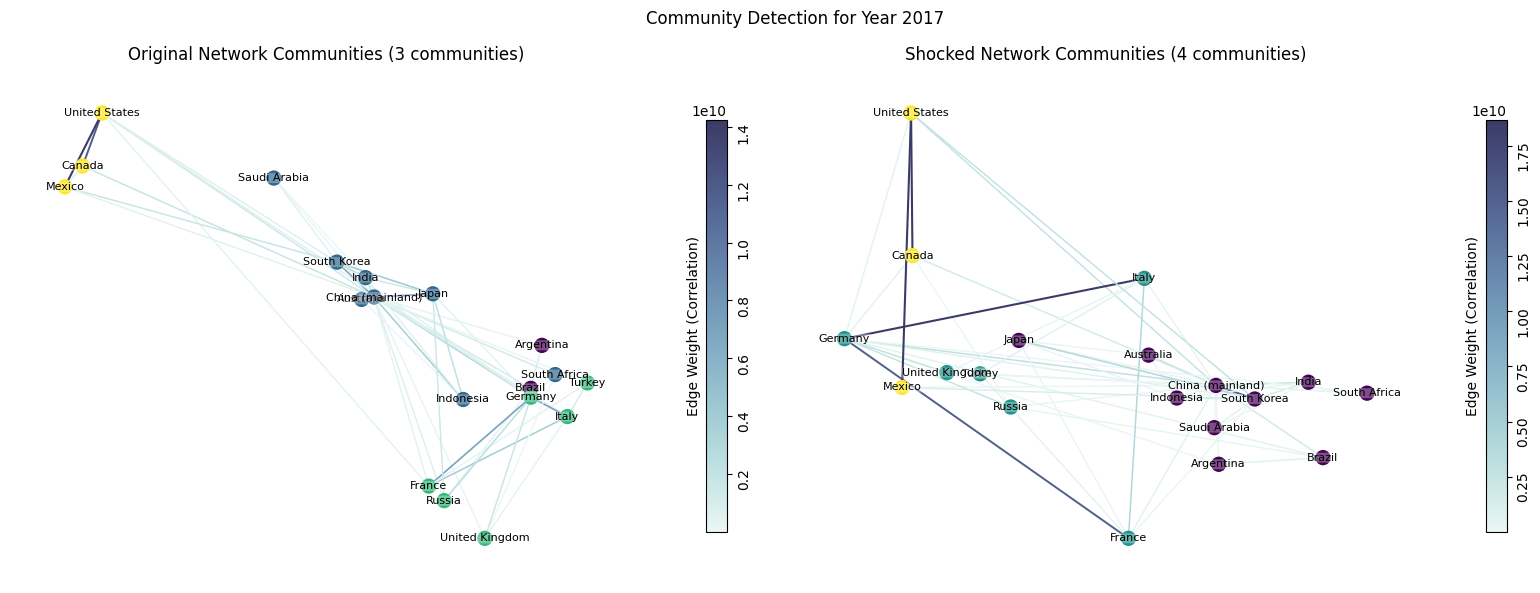

random seed: 42


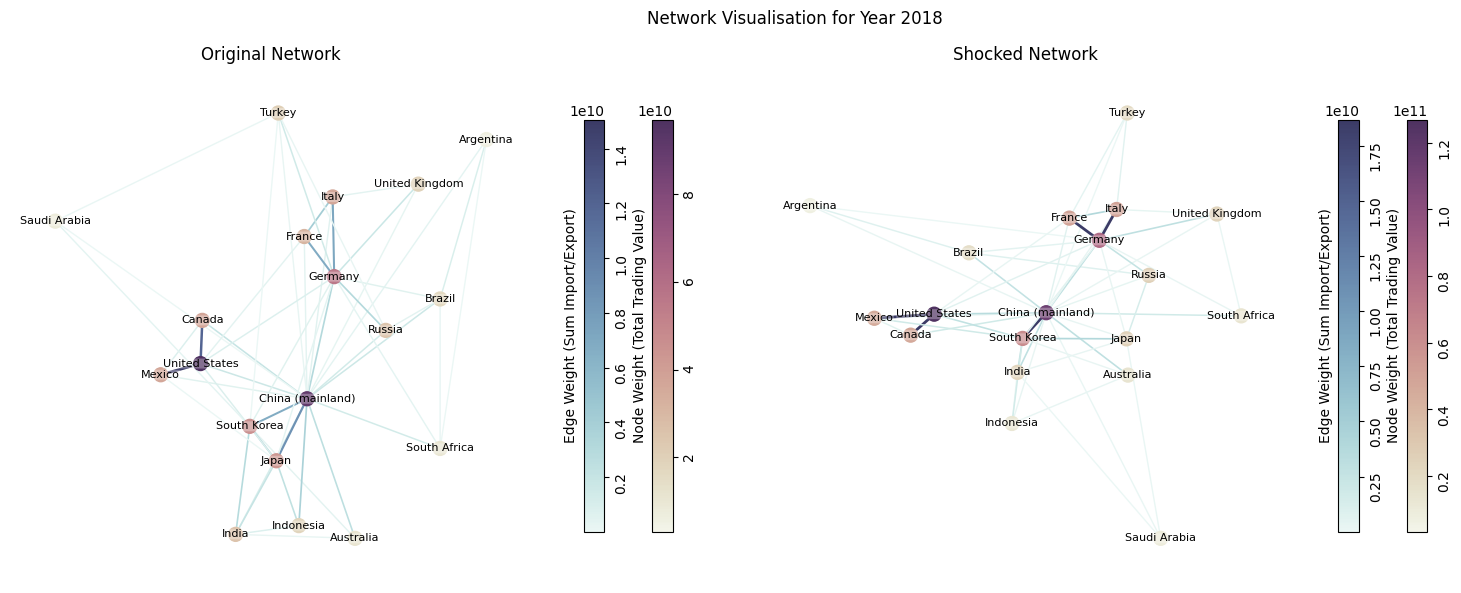

louvain_communities found 3 communities
louvain_communities found 3 communities


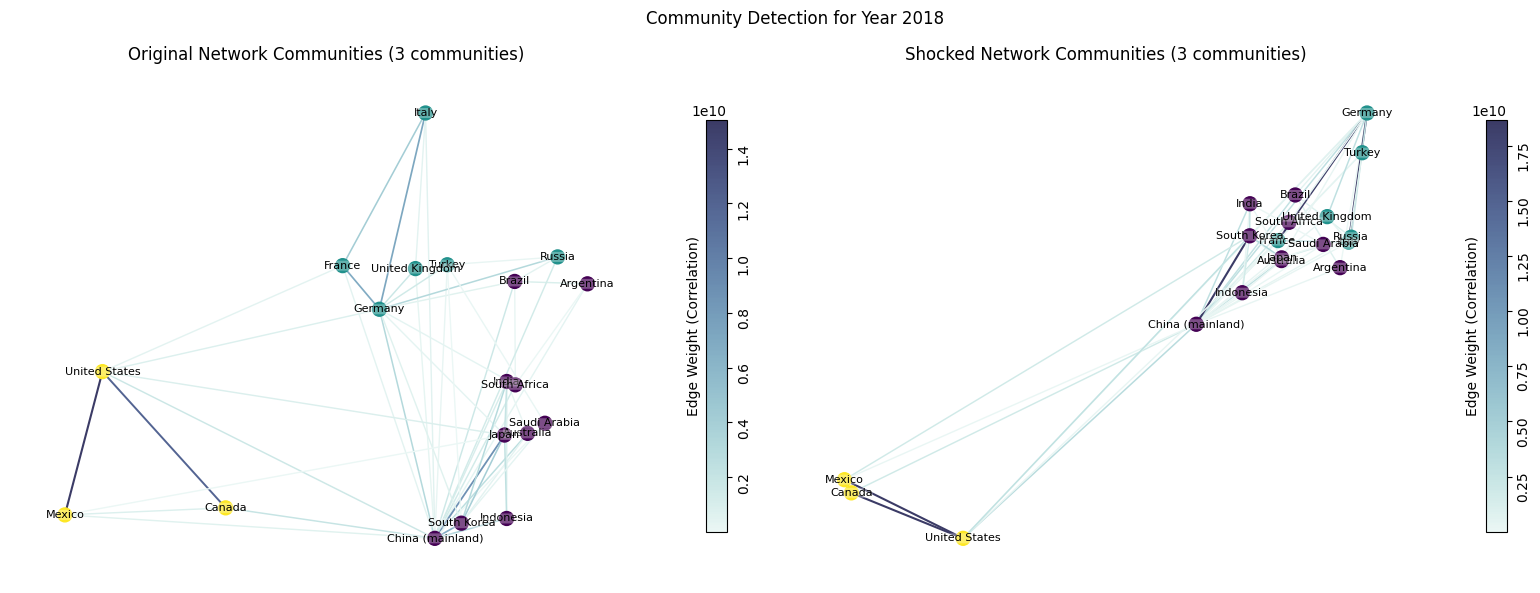

random seed: 42


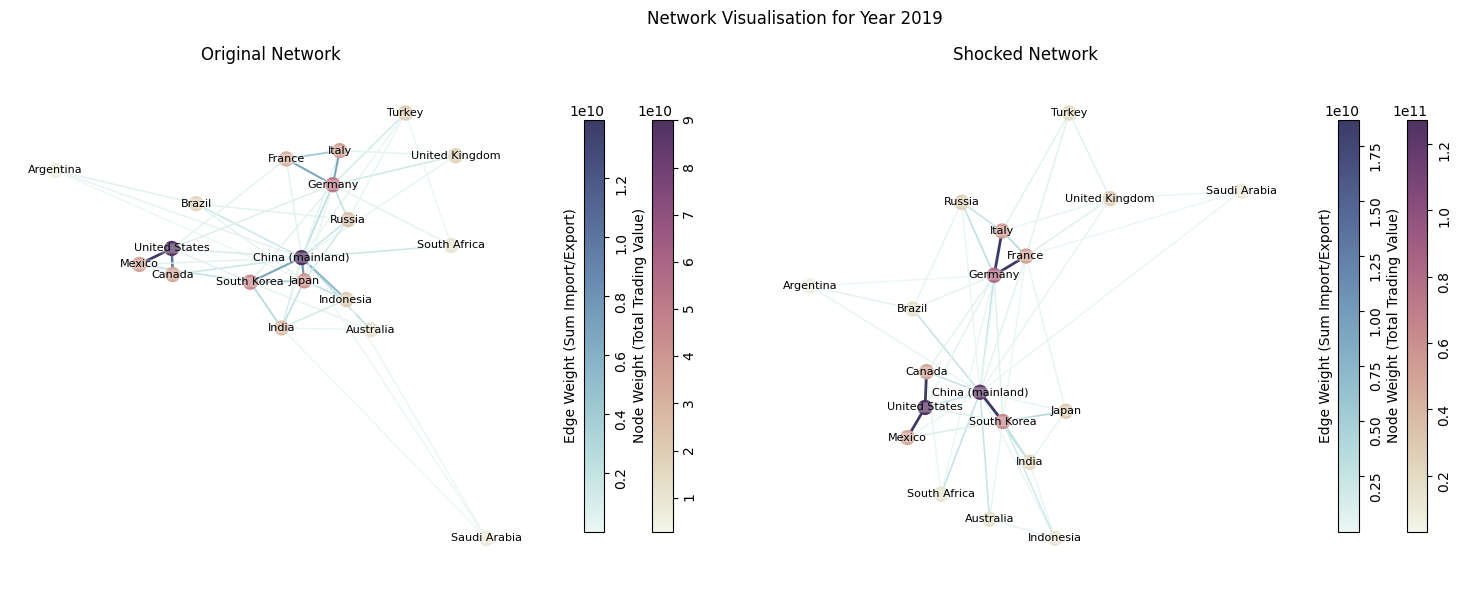

louvain_communities found 3 communities
louvain_communities found 3 communities


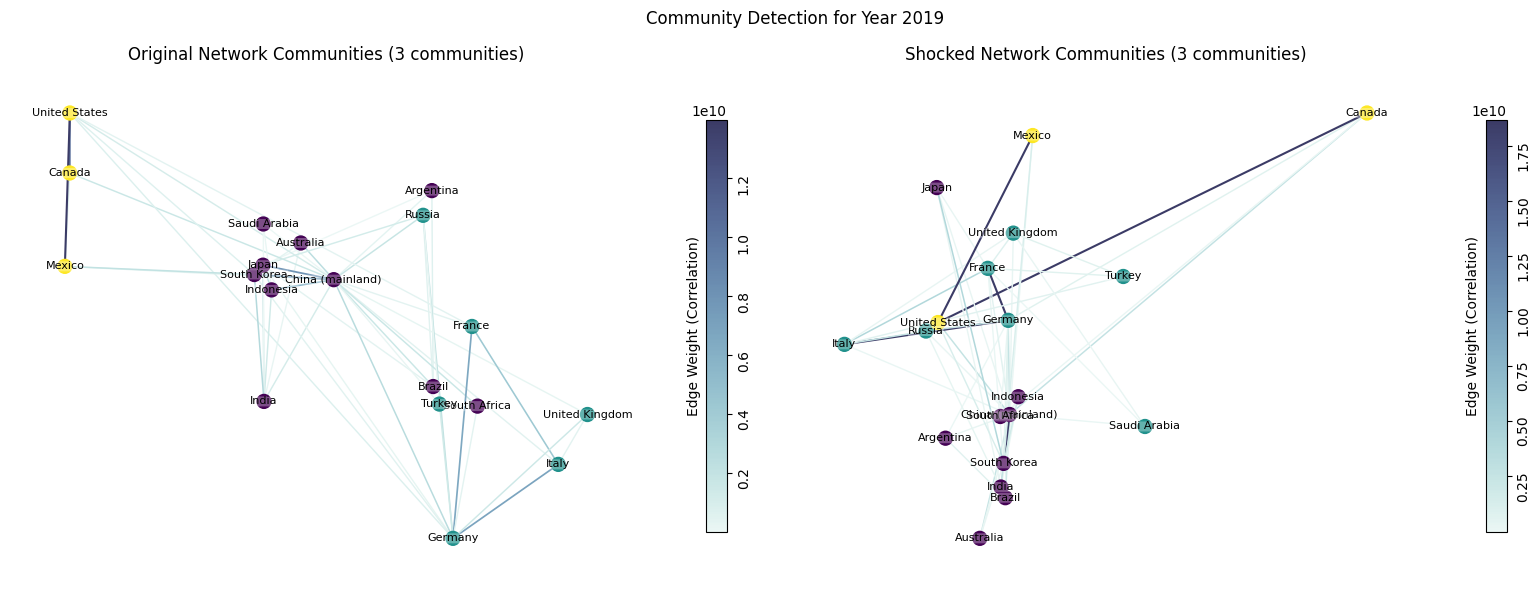

In [26]:
def general_network_visualisation(original_G, embargoed_G, year, seed=np.random.randint(0, 1000), savefig=False):
    print(f"random seed: {seed}")

    # Create snapshots
    original_snap = model.create_static_snapshot(G=original_G, year=year)
    shocked_snap = model.create_static_snapshot(G=embargoed_G, year=year)

    # Plotting network visualisation
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Network Visualisation for Year {year}")

    ax[0].set_title("Original Network")
    original_tmfg = plot_value_tmfg(
        G=original_snap,
        node_cmap=sns.color_palette("ch:s=-0.2,r=0.6,light=0.95,dark=0.25", as_cmap=True),
        edge_cmap = sns.color_palette("ch:start=0.2,rot=-0.3,light=0.95,dark=0.25", as_cmap=True),
        seed=seed,
        ax=ax[0]
    )
    ax[1].set_title("Shocked Network")
    shocked_tmfg = plot_value_tmfg(
        G=shocked_snap,
        node_cmap=sns.color_palette("ch:s=-0.2,r=0.6,light=0.95,dark=0.25", as_cmap=True),
        edge_cmap = sns.color_palette("ch:start=0.2,rot=-0.3,light=0.95,dark=0.25", as_cmap=True),
        seed=seed,
        ax=ax[1]
    )
    plt.tight_layout()
    if savefig:
        plt.savefig(f"embargo_visualisation_{year}.png", dpi=600)
    plt.show()

    # Plotting community visualisation
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Community Detection for Year {year}")

    original_communities = plot_communities(original_tmfg, method=nx.algorithms.community.louvain_communities, seed=seed, ax=ax[0])
    shocked_communities = plot_communities(shocked_tmfg, method=nx.algorithms.community.louvain_communities, seed=seed, ax=ax[1])

    ax[0].set_title(f"Original Network Communities ({len(shocked_communities)} communities)")
    ax[1].set_title(f"Shocked Network Communities ({len(original_communities)} communities)")

    plt.tight_layout()
    if savefig:
        plt.savefig(f"embargo_communities_{year}.png", dpi=600)
    plt.show()

for year in range(2014, 2020):
    general_network_visualisation(original_G, embargoed_G, year=year, seed=42, savefig=True)